# RNN Track Filter for tree search

In this notebook we will take the trained RNN hit predictor and apply it to track search on ACTS events.

In [1]:
# Select a GPU first
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
os.environ['OMP_NUM_THREADS'] = '4'
cuda = False

In [2]:
from __future__ import print_function

# Data libraries
import numpy as np
import pandas as pd

# Deep learning
import torch

# Visualization
import matplotlib.pyplot as plt

# Local imports
from data import process_files
from track_filter import (select_hits, select_signal_hits,
                          remove_duplicate_hits, coord_scale)
import torchutils
torchutils.set_cuda(cuda)

%matplotlib notebook

In [15]:
def calc_eta(r, z):
    theta = np.arctan2(r, z)
    return -1. * np.log(np.tan(theta / 2.))

def calc_dphi(phi1, phi2):
    dphi = np.abs(phi1 - phi2)
    idx = dphi > np.pi
    dphi[idx] = 2*np.pi - dphi[idx]
    return dphi

def calc_dR(eta1, eta2, phi1, phi2):
    deta = np.abs(eta1 - eta2)
    dphi = calc_dphi(phi1, phi2)
    return np.sqrt(deta*deta + dphi*dphi)

def calc_phi_z_distance(phi1, phi2, z1, z2):
    dphi = calc_dphi(phi1, phi2)
    dz = np.abs(z1 - z2)
    return np.sqrt(dphi*dphi + dz*dz)

def calc_eta(r, z):
    theta = np.arctan2(r, z)
    return -1. * np.log(np.tan(theta / 2.))

def calc_eta_phi_distance(r1, phi1, z1, r2, phi2, z2):
    # First, calculate the eta coordinates
    eta1 = calc_eta(r1, z1)
    eta2 = calc_eta(r2, z2)
    deta = np.abs(eta1 - eta2)
    dphi = calc_dphi(phi1, phi2)
    return np.sqrt(dphi*dphi + deta*deta)    

In [4]:
data_dir = '/global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29'
model_file = '/global/cscratch1/sd/sfarrell/heptrkx/RNNFilter/model'

In [5]:
n_files = 1

all_files = os.listdir(data_dir)
hits_files = sorted(f for f in all_files if f.startswith('clusters'))
hits_files = [os.path.join(data_dir, f) for f in hits_files[:n_files]]

In [6]:
%%time

n_workers = 1
hits = process_files(hits_files, num_workers=n_workers)

Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_1.csv
CPU times: user 72.2 ms, sys: 53.7 ms, total: 126 ms
Wall time: 1min 11s


In [7]:
print('Hits data shape:', hits.shape)

Hits data shape: (520540, 7)


In [8]:
%%time

# Select hits
selected_hits = remove_duplicate_hits(select_hits(hits))
print('selected barrel hits:', selected_hits.shape)
signal_hits = select_signal_hits(selected_hits)
print('signal track hits:', signal_hits.shape)

selected barrel hits: (265715, 7)
signal track hits: (134990, 7)
CPU times: user 7 s, sys: 56 ms, total: 7.06 s
Wall time: 7.1 s


In [11]:
event_groups = selected_hits.groupby('evtid')
sample_keys = signal_hits[['evtid', 'barcode']].drop_duplicates().values

In [50]:
print('Available sample keys:', sample_keys.shape[0])

Available sample keys: 13499


In [10]:
# Load the pre-trained model
model = torch.load(model_file)
model.eval()
model

HitPredictor (
  (lstm): LSTM(3, 20, batch_first=True)
  (fc): Linear (20 -> 2)
)

In [16]:
def make_inputs(x):
    return torchutils.np_to_torch(
        (x[['phi', 'z', 'layer']].values / coord_scale)
        .astype(np.float32))

In [51]:
n_det_layers = 10
seed_size = 3

n_test = 10240

In [52]:
%%time

# Selected hit entries for every sample
sel_indices = []
# True labels of all selected hit entries
sel_labels = []

# Loop over samples
for k in sample_keys[:n_test]:

    # Gather the data
    sample_hits = event_groups.get_group(k[0]).sort_values('layer')
    sample_labels = sample_hits.barcode == k[1]

    # Prepare the seed
    seed_hits = sample_hits[(sample_hits.layer < seed_size) &
                            (sample_hits.barcode == k[1])]
    sel_idx = seed_hits.index

    for layer in range(seed_size, n_det_layers):

        # Calculate the prediction for next layer
        model_input = make_inputs(sample_hits.loc[sel_idx])[None, :]
        model_pred = model(model_input)[0, -1]
        pred = torchutils.torch_to_np(model_pred) * coord_scale[:2]

        # Select all hits on the next layer
        layer_hits = sample_hits[sample_hits.layer == layer]

        # Calculate distance from prediction.
        # TODO: I probably should use eta-phi distance
        #distances = calc_phi_z_distance(pred[0], layer_hits.phi, pred[1], layer_hits.z)
        distances = calc_eta_phi_distance(layer_hits.r, layer_hits.phi, layer_hits.z,
                                          layer_hits.r, pred[0], pred[1])

        # Select the closes
        next_idx = distances.argmin()
        sel_idx = sel_idx.append(pd.Int64Index([next_idx]))
    
    sel_indices.append(sel_idx)
    sel_labels.append(sample_labels.loc[sel_idx])

# Stack the results into full dataset tensors
sel_labels = np.stack(sel_labels)
sel_indices = np.stack(sel_indices)

CPU times: user 11min 27s, sys: 3.08 s, total: 11min 30s
Wall time: 11min 30s


In [53]:
print('Fraction of correctly selected hits:', sel_labels[:, seed_size:].mean())

Fraction of correctly selected hits: 0.605385044643


### Visualize some samples

<IPython.core.display.Javascript object>


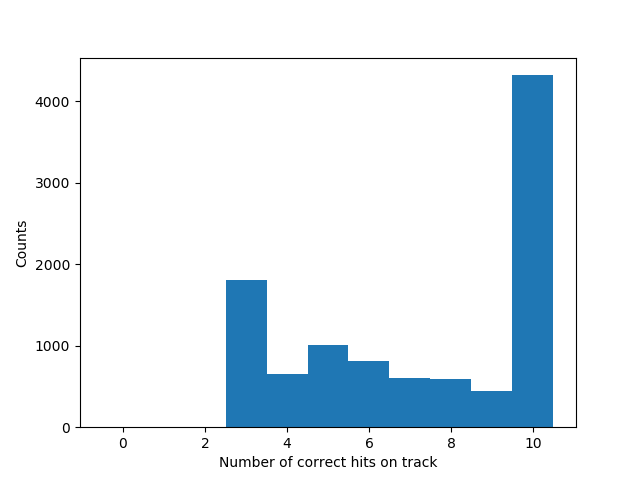

In [55]:
# Draw histogram of the number of correct hits in the predictions
correct_counts = sel_labels.sum(axis=1)

plt.figure()
plt.hist(correct_counts, range=(-0.5, 10.5), bins=11)
plt.xlabel('Number of correct hits on track')
plt.ylabel('Counts');

In [56]:
draw_samples = np.random.randint(n_test, size=5)
#draw_samples = [25, 48, 42, 64, 331, 228]

<IPython.core.display.Javascript object>


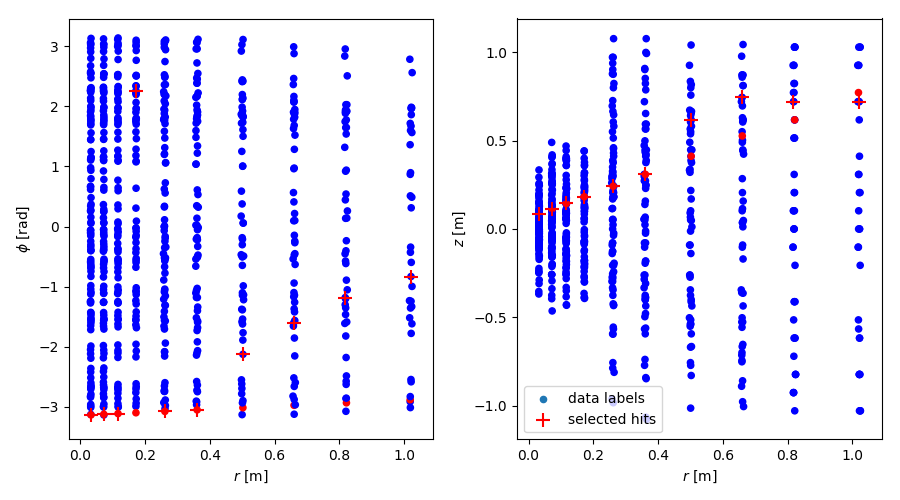

<IPython.core.display.Javascript object>


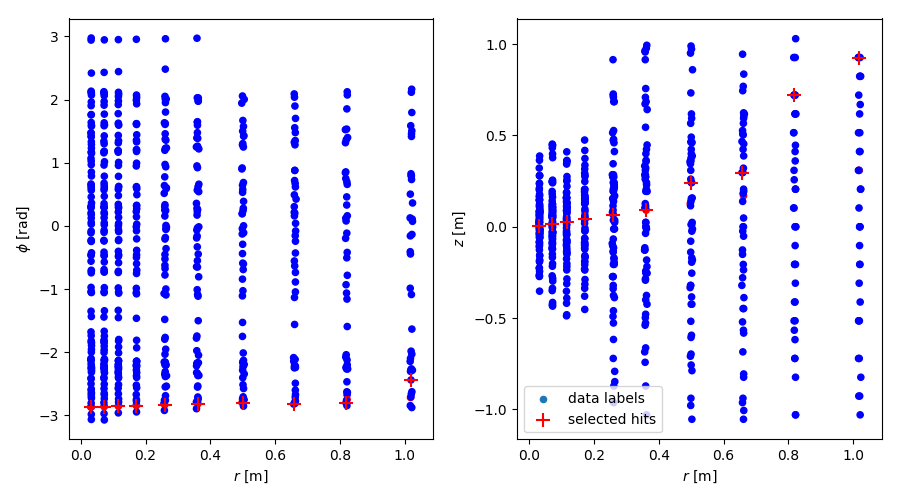

<IPython.core.display.Javascript object>


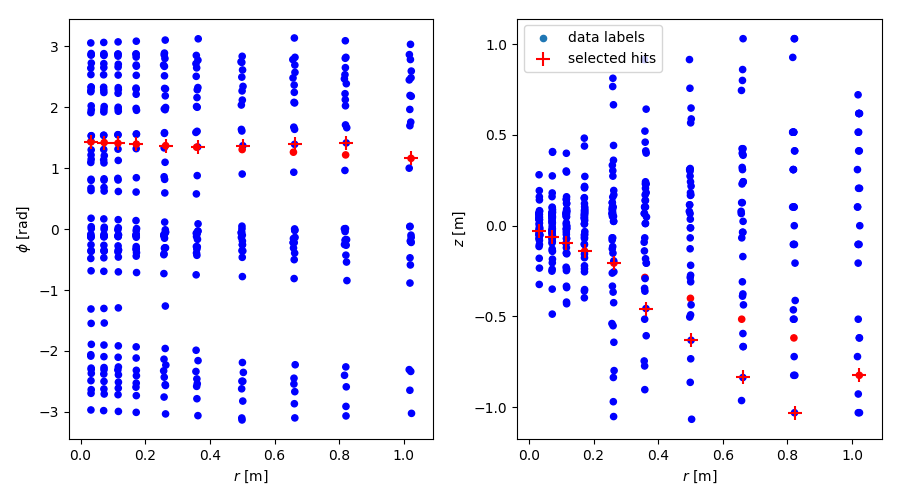

<IPython.core.display.Javascript object>


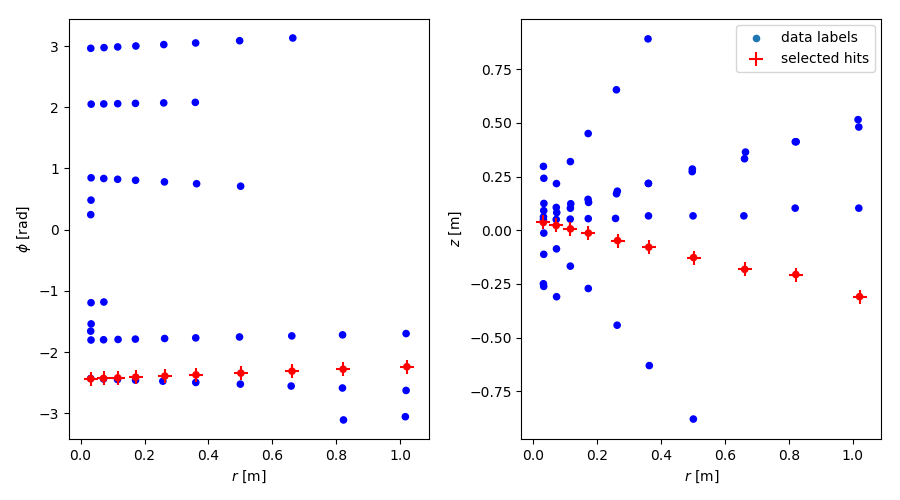

<IPython.core.display.Javascript object>


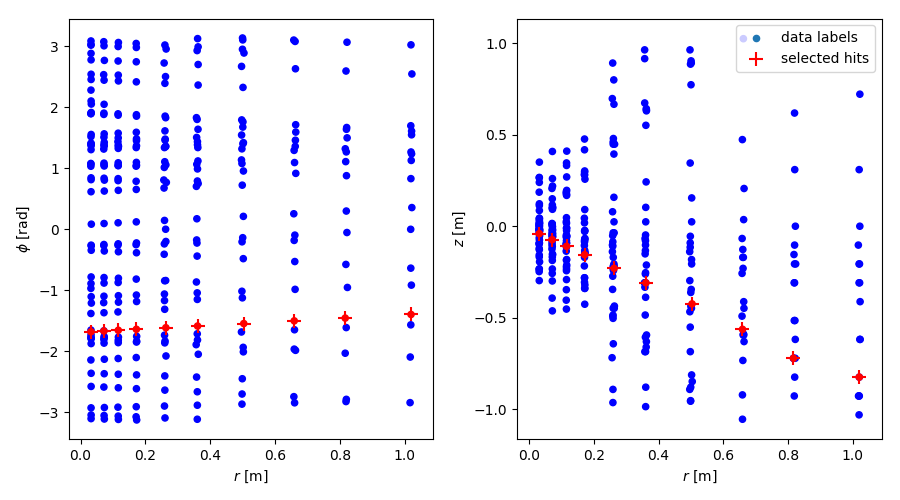

In [57]:
# Loop over samples to draw
for isample in draw_samples:
    sample_key = sample_keys[isample]

    # Get the hits for this sample
    sample_hits = event_groups.get_group(sample_key[0])
    sample_labels = sample_hits.barcode == sample_key[1]

    # Get the hits selected by our model
    sample_sel_idx = pd.Int64Index(sel_indices[isample])
    sample_sel_hits = sample_hits.loc[sample_sel_idx]

    plt.figure(figsize=(9, 5))
    plt.subplot(121)
    plt.scatter(sample_hits.r*0.001, sample_hits.phi, c=sample_labels, s=20, cmap='bwr', label='data labels')
    plt.scatter(sample_sel_hits.r*0.001, sample_sel_hits.phi, marker='+', c='r', s=100, label='selected hits')
    plt.xlabel('$r$ [m]')
    plt.ylabel('$\phi$ [rad]')

    plt.subplot(122)
    plt.scatter(sample_hits.r*0.001, sample_hits.z*0.001, c=sample_labels, s=20, cmap='bwr', label='data labels')
    plt.scatter(sample_sel_hits.r*0.001, sample_sel_hits.z*0.001, marker='+', c='r', s=100, label='selected hits')
    plt.xlabel('$r$ [m]')
    plt.ylabel('$z$ [m]')
    plt.legend(loc=0)

    plt.tight_layout()